## Airbnb New User First Booking Classification

### Description

First-time Airbnb users can book a stay in over 34,000+ cities across 190+ countries. To provide more personalized user recommendations, it is import to forecast the destination a user might choose for their first booking. In response to a <a href="https://www.kaggle.com/competitions/airbnb-recruiting-new-user-bookings">Kaggle challenge hosted by Airbnb</a>, the purpose of this project is to classify the destination country of a user's first booking. Destinations include 10 possible countries spanning across North America, Europe, and Australia, some other country beyond these, or no booking at all.

### Approach

For classification, I used a combination of user-level features and aggregted session-level features that I engineered from Airbnb session log data. All feature preprocessing, feature selection, and modeling occured in a pipeline to prevent data leakage. For modeling, I trained a (1) logistic regression model, (2) k-nearest neighbors classifier, (3) random forest classifier, and (4) support vector machine (with rbf kernel). The hyperparameters for each model were tuned using GridSearchCV and NDCG @ 5 scoring (following the evaluation metric specified by Airbnb). The entire hyperparameter gridsearch was cross-validated using a nested cross-validation approach. The model that produced the best NDCG @ 5 score was used to make final predictions on the test set.

### Importing Libraries

In [1]:
# Basic Data Analysis/Visualization 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from custom_sklearn_transformers import KNNImputerSubset, SelectivePowerTransformer
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline, Pipeline

# Feature Selection
from sklearn.feature_selection import mutual_info_classif, VarianceThreshold, SelectPercentile
from custom_sklearn_transformers import RFECVSubset
from sklearn.tree import DecisionTreeClassifier

# Model Selection and Evaluation 
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.kernel_approximation import Nystroem
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer

# Custom Functions
from airbnb_classification_functions import (
    extract_datetime_units,
    univariate_visualization,
    bivariate_visualization,
    get_NDCG,
    get_top_5_predictions,
    svm_ndcg_scorer
)

### Importing and Examining Datasets

Training data is in <b>"train_users_2.csv"</b>, and test data is in <b>"test_users.csv"</b>. The training data includes user-level account data and the target ("country_destination"), while the test data includes only user-level account data.

Additional predictor features are in <b>"aggregated_sessions_data.csv"</b>, which contains aggregated session-level account data, which I engineered from raw user sessions logs in <b>"sessions.csv"</b>. For the sessions feature engineering workflow, see <b>"Session Log Feature Engineering.ipynb"</b>.

In [2]:
df_train = pd.read_csv("datasets/train_users_2.csv", index_col="id")
df_test = pd.read_csv("datasets/test_users.csv", index_col="id")
sessions = pd.read_csv("datasets/aggregated_sessions_data.csv", index_col="user_id", float_precision="round_trip")

In [3]:
train_dates = pd.to_datetime(df_train["timestamp_first_active"], format="%Y%m%d%H%M%S")

print(f"Dates range from {train_dates.min()} - {train_dates.max()}\n\n")

df_train.info()

Dates range from 2009-03-19 04:32:55 - 2014-06-30 23:58:24


<class 'pandas.core.frame.DataFrame'>
Index: 213451 entries, gxn3p5htnn to nw9fwlyb5f
Data columns (total 15 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   date_account_created     213451 non-null  object 
 1   timestamp_first_active   213451 non-null  int64  
 2   date_first_booking       88908 non-null   object 
 3   gender                   213451 non-null  object 
 4   age                      125461 non-null  float64
 5   signup_method            213451 non-null  object 
 6   signup_flow              213451 non-null  int64  
 7   language                 213451 non-null  object 
 8   affiliate_channel        213451 non-null  object 
 9   affiliate_provider       213451 non-null  object 
 10  first_affiliate_tracked  207386 non-null  object 
 11  signup_app               213451 non-null  object 
 12  first_device_type        213451 non-null  obj

In [4]:
test_dates = pd.to_datetime(df_test["timestamp_first_active"], format="%Y%m%d%H%M%S")

print(f"Dates range from {test_dates.min()} - {test_dates.max()}\n\n")

df_test.info()

Dates range from 2014-07-01 00:00:06 - 2014-09-30 23:59:01


<class 'pandas.core.frame.DataFrame'>
Index: 62096 entries, 5uwns89zht to 9uqfg8txu3
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   date_account_created     62096 non-null  object 
 1   timestamp_first_active   62096 non-null  int64  
 2   date_first_booking       0 non-null      float64
 3   gender                   62096 non-null  object 
 4   age                      33220 non-null  float64
 5   signup_method            62096 non-null  object 
 6   signup_flow              62096 non-null  int64  
 7   language                 62096 non-null  object 
 8   affiliate_channel        62096 non-null  object 
 9   affiliate_provider       62096 non-null  object 
 10  first_affiliate_tracked  62076 non-null  object 
 11  signup_app               62096 non-null  object 
 12  first_device_type        62096 non-null  object 
 13  first_

Although the sessions data does not include dates, the date range is from 01/01/2014 to 07/01/2014.

Merging sessions data with training and testing data.

In [5]:
df_train = df_train.merge(sessions, how="left", right_index=True, left_index=True, indicator=True)
df_test = df_test.merge(sessions, how="left", right_index=True, left_index=True, indicator=True)

display(df_train["_merge"].value_counts())
display(df_test["_merge"].value_counts())

left_only     139636
both           73815
right_only         0
Name: _merge, dtype: int64

both          61668
left_only       428
right_only        0
Name: _merge, dtype: int64

Of the 213,451 users in the training data, 73,815 had sessions data. Almost all users in the test dataset have sessions data.

For these analyses, I will only train models on users with sessions data in order to make use of the aggregated sessions features, which reflect the most recent user behavior in the six months directly preceding the test data. 

In [6]:
df_train = (df_train
            .loc[df_train["_merge"] == "both", :]
            .drop("_merge", axis=1))

X_test = df_test.drop("_merge", axis=1)

### Exploratory Data Analysis

In [7]:
X_train = df_train.drop("country_destination", axis=1)
y_train = df_train["country_destination"]

##### Examining Univariate Distributions for Categorical Features

Before examining categorical features, I will first extract datetime features from "date_account_created", "date_first_booking", and "timestamp_first_active".

In [8]:
dt_features = ["date_account_created", "date_first_booking", "timestamp_first_active"]
dt_formatting = ["%Y-%m-%d", "%Y-%m-%d", "%Y%m%d%H%M%S"]
dt_units = ["year", "month", "dayofweek", "quarter"]
        
X_train = extract_datetime_units(X_train, dt_features, dt_formatting, dt_units)
X_test = extract_datetime_units(X_test, dt_features, dt_formatting, dt_units)

Next, I will examine the univariate distributions for all categorical features.

In [9]:
categorical_features = X_train.select_dtypes("object").columns.tolist()

print(f"Number of categorical features: {len(categorical_features)}")

Number of categorical features: 21


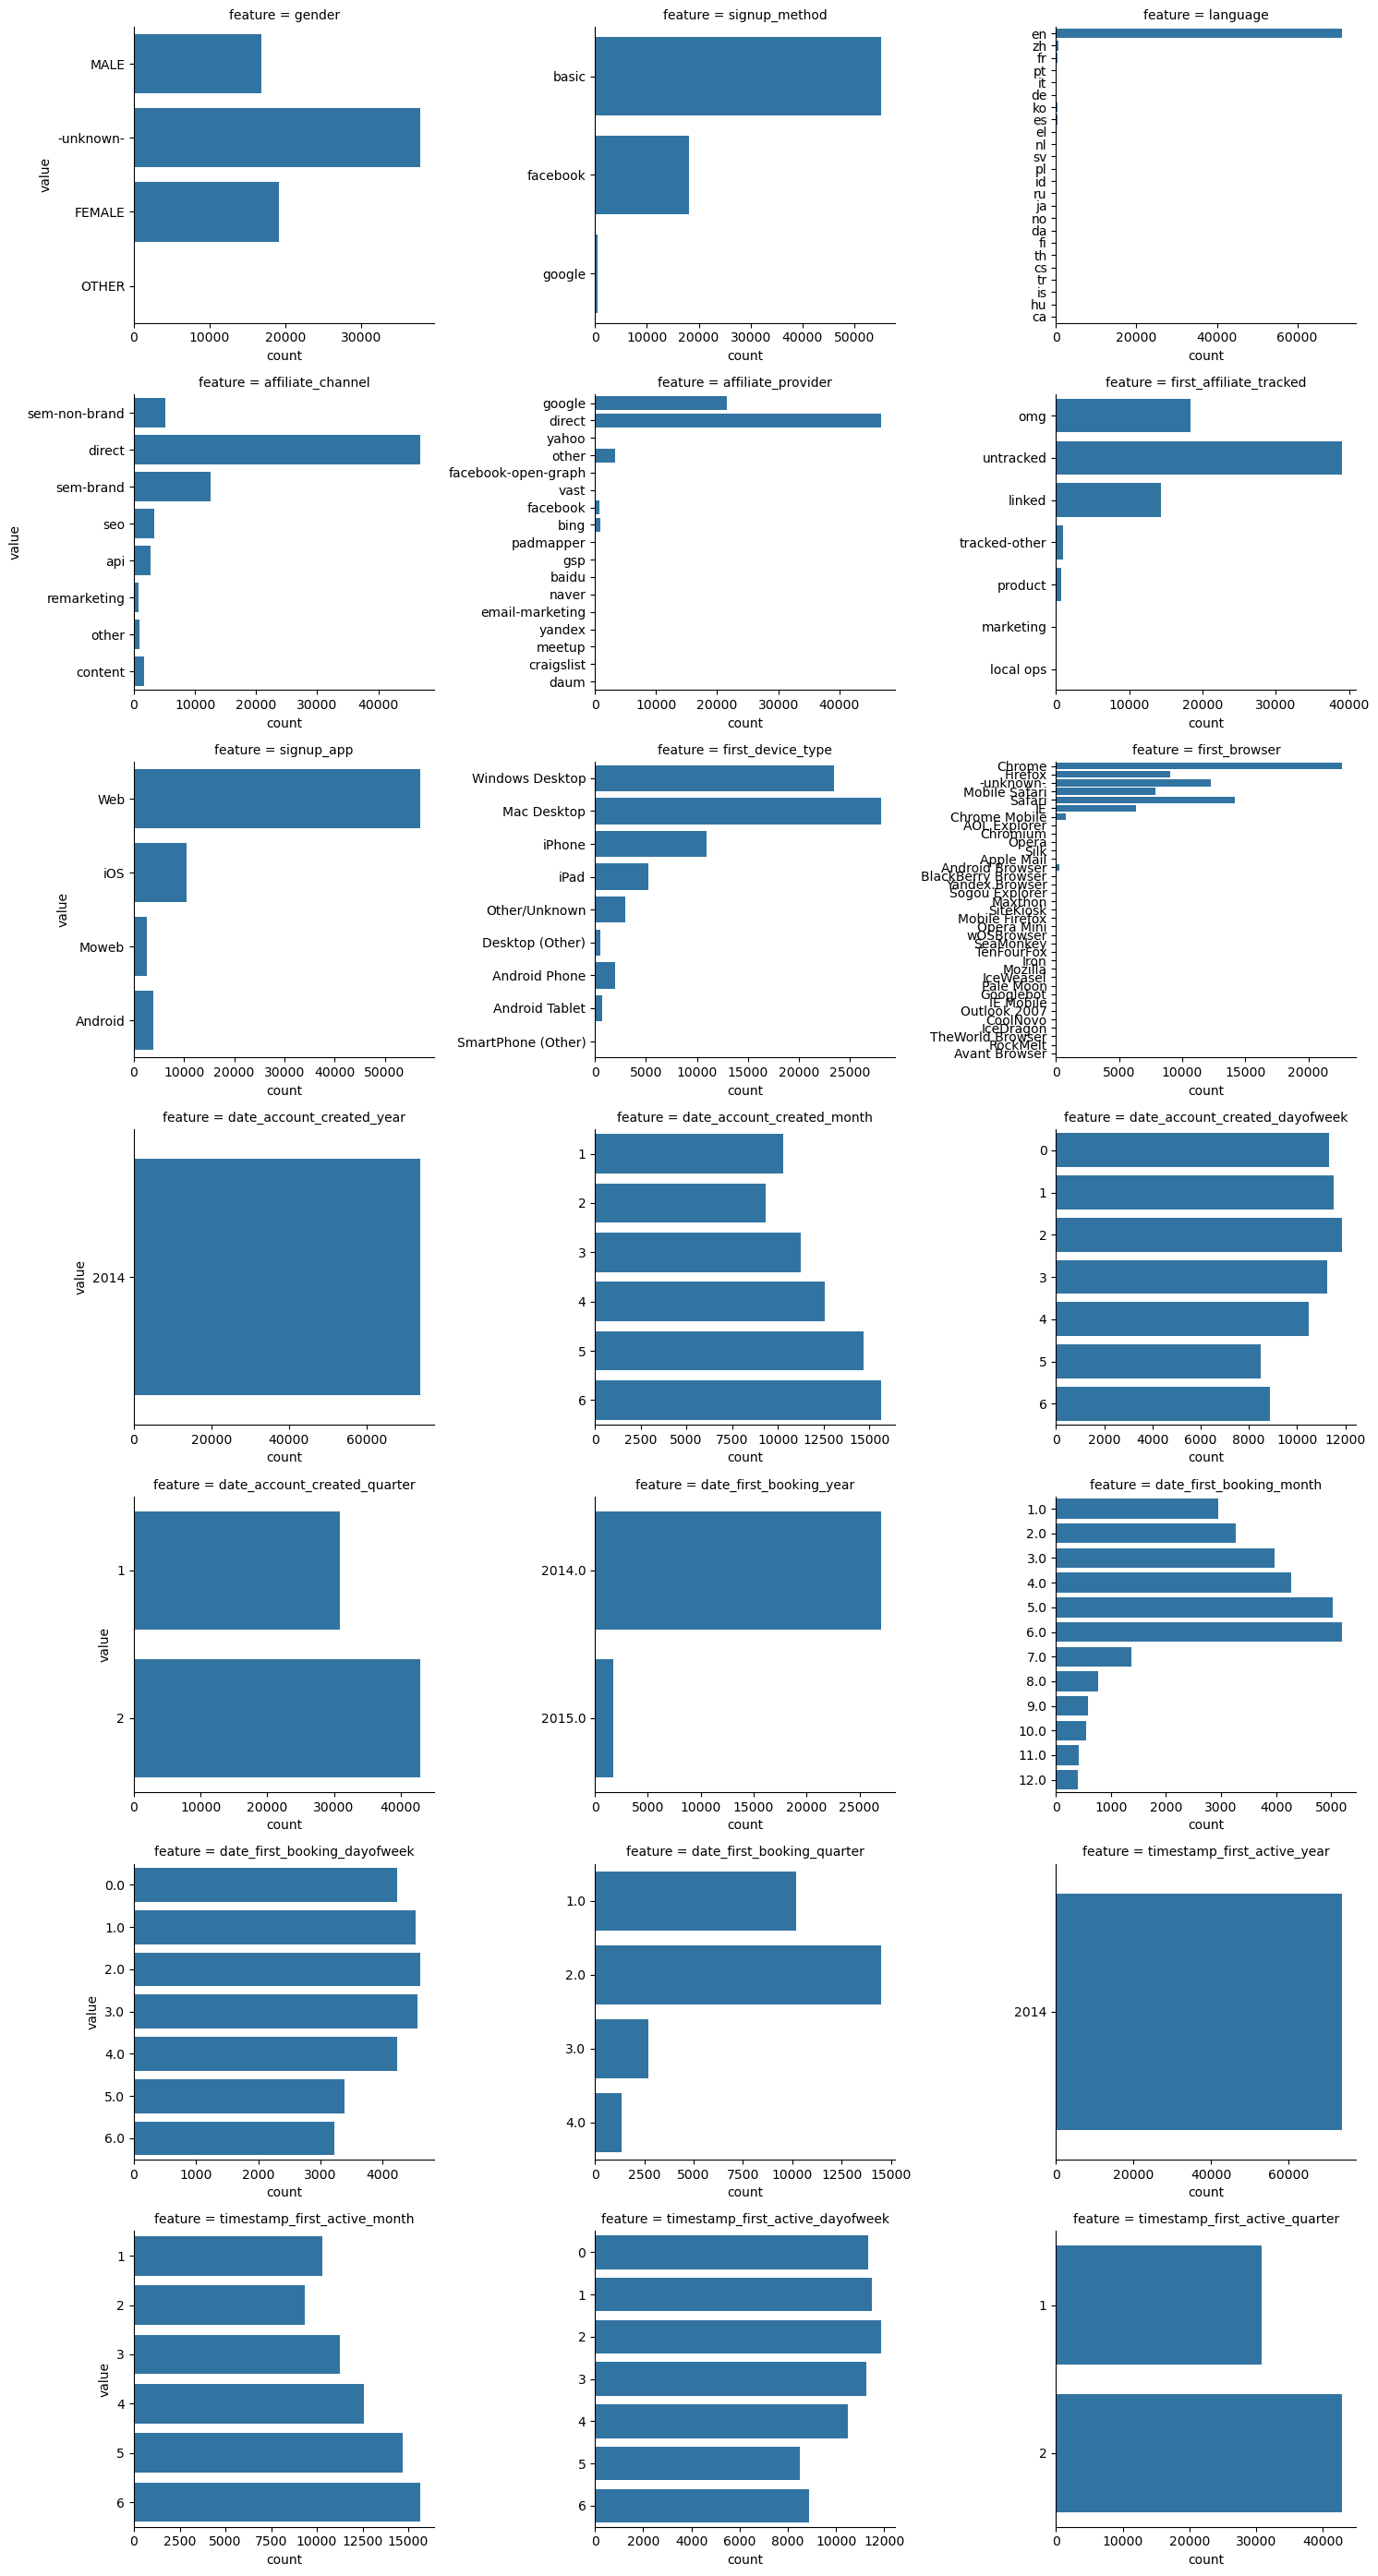

In [10]:
univariate_visualization(data=X_train[categorical_features],
                         data_type="categorical",
                         orientation="h", 
                         figsize=(5, 4))

Some features (e.g., gender) have an "unknown" category rather than missing values. Since the fact that these values are missing may be meaningful for the purposes of classification, I will leave the "unknown" categories as is.

Two features ("date_account_created_year" and "timestamp_first_active_year") are all one value. During feature selection, I will exclude any features with zero variance so these features will be removed.

Many other features have categories with very few values. When one hot encoding these features, I will encode all categories that comprise less than 1% of values for a given feature as a single infrequent category.

##### Examining Univariate Distributions for Numeric Features

In [11]:
numeric_features = X_train.select_dtypes("number").columns.tolist()

print(f"Number of numeric features: {len(numeric_features)}")

Number of numeric features: 62


Examining descriptive statistics for numeric features.

In [12]:
with pd.option_context("display.max_columns", None):
    display(X_train.describe())

,age,signup_flow,action_num,action_n_unique,action_type_n_unique,action_detail_n_unique,device_type_n_unique,action_active,action_ajax_refresh_subtotal,action_collections,action_create,action_dashboard,action_edit,action_header_userpic,action_index,action_lookup,action_personalize,action_reviews,action_search,action_search_results,action_show,action_similar_listings,action_similar_listings_v2,action_social_connections,action_update,action_infrequent_sklearn,action_type_-unknown-,action_type_click,action_type_data,action_type_missing,action_type_submit,action_type_view,action_type_infrequent_sklearn,action_detail_-unknown-,action_detail_change_trip_characteristics,action_detail_dashboard,action_detail_edit_profile,action_detail_header_userpic,action_detail_listing_reviews,action_detail_message_thread,action_detail_missing,action_detail_p3,action_detail_similar_listings,action_detail_update_listing,action_detail_user_profile,action_detail_user_social_connections,action_detail_user_wishlists,action_detail_view_search_results,action_detail_wishlist_content_update,action_detail_infrequent_sklearn,device_type_-unknown-,device_type_Android App Unknown Phone/Tablet,device_type_Android Phone,device_type_Mac Desktop,device_type_Tablet,device_type_Windows Desktop,device_type_iPad Tablet,device_type_iPhone,device_type_infrequent_sklearn,se_mean,se_std,se_skew
count,41567.000000,73815.000000,73815.000000,73815.000000,73815.000000,73815.000000,73815.000000,73815.000000,73815.000000,73815.000000,73815.000000,73815.000000,73815.000000,73815.000000,73815.000000,73815.000000,73815.000000,73815.000000,73815.000000,73815.000000,73815.000000,73815.000000,73815.000000,73815.000000,73815.000000,73815.000000,73815.000000,73815.000000,73815.000000,73815.00000,73815.000000,73815.000000,73815.000000,73815.000000,73815.000000,73815.000000,73815.000000,73815.000000,73815.000000,73815.000000,73815.00000,73815.000000,73815.000000,73815.000000,73815.000000,73815.000000,73815.000000,73815.000000,73815.000000,73815.000000,73815.000000,73815.000000,73815.000000,73815.000000,73815.000000,73815.000000,73815.000000,73815.000000,73815.000000,7.263100e+04,6.985000e+04,68460.000000
mean,42.414993,4.856208,75.024819,12.922699,5.607085,11.563300,1.313663,1.153776,4.277803,0.826607,1.149712,1.003319,0.758816,1.149861,6.273698,1.845316,6.092976,1.354725,2.802059,5.685687,17.637391,4.171876,0.183933,1.969315,2.792319,13.895631,7.651602,14.420321,16.100996,8.39748,4.841441,22.620375,0.992603,7.651602,4.277803,1.003319,0.755510,1.149861,1.127549,1.054515,8.39748,8.265366,4.171876,2.104599,3.634370,1.939687,1.042403,12.365874,6.092976,9.990029,1.337547,3.614618,2.838014,29.134932,0.716873,21.037892,5.215376,10.664228,0.465339,3.266175e+04,8.443564e+04,4.382887
std,111.201954,9.339480,112.543174,8.172772,1.721079,6.218617,0.558021,4.049106,9.715277,5.049064,1.817456,1.955080,2.607723,2.441691,13.222963,8.794801,13.309548,6.510678,17.605647,16.665340,36.211009,10.017971,2.351095,9.196071,9.706235,24.761102,21.573845,29.473565,28.112457,18.38150,10.155377,40.316986,2.028958,21.573845,9.715277,1.955080,2.599208,2.441691,5.696832,5.194184,18.38150,20.404410,10.017971,8.067765,14.323909,9.129232,5.170131,28.445897,13.309548,14.553919,8.784445,31.807666,32.870450,76.563535,16.022678,63.351197,33.327530,50.374706,8.899507,6.039221e+04,9.720939e+04,2.733822
min,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,-1.893510
25%,27.000000,0.000000,13.000000,8.000000,5.000000,8.000000,1.000000,

Examining univariate distributions for numeric features.

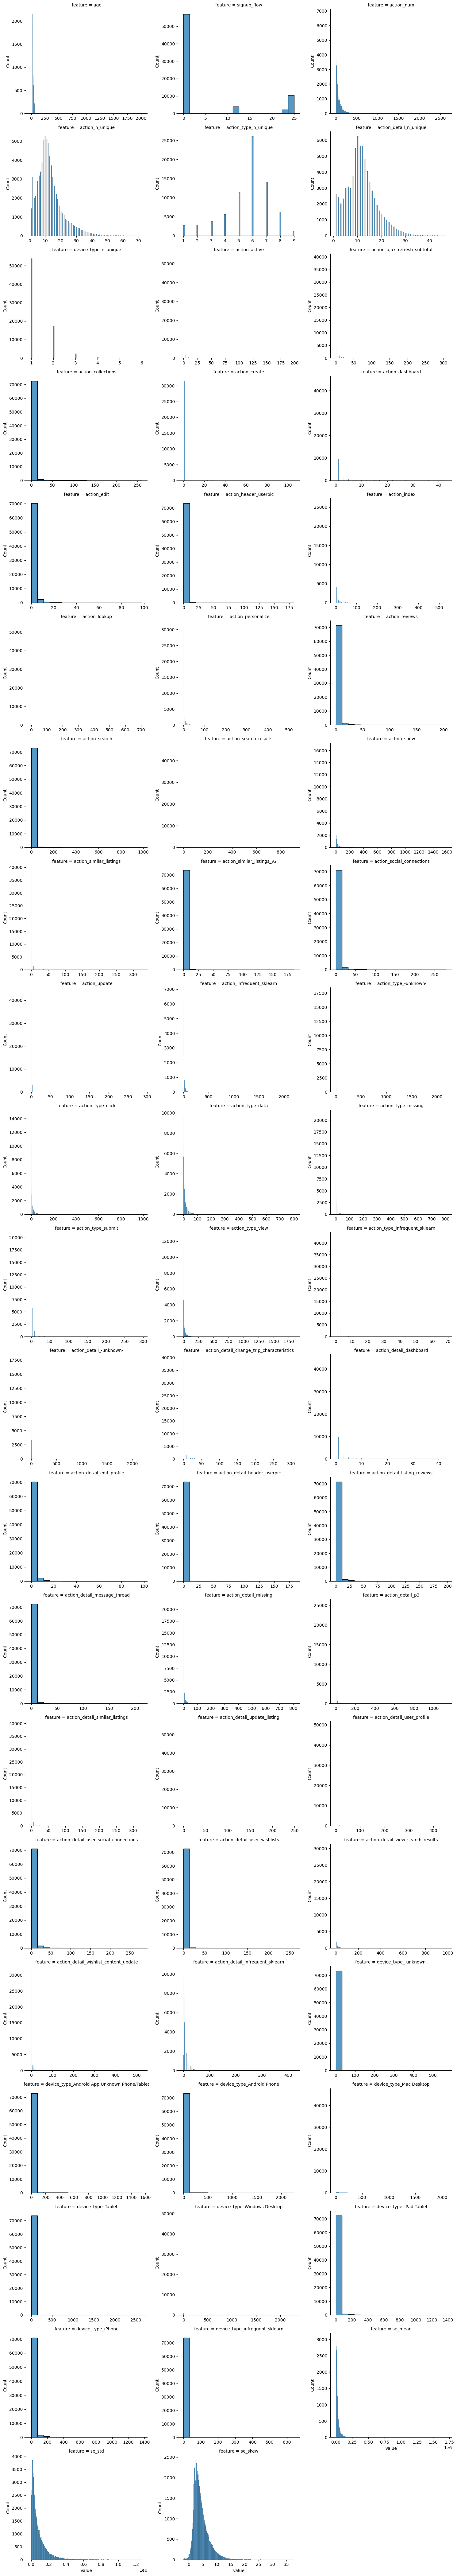

In [13]:
univariate_visualization(data=X_train[numeric_features],
                         data_type="numeric", 
                         orientation="v",
                         figsize=(5, 4))

One feature ("age") shows obviously erroneous values (e.g., 2014). All unreasonable age values will be set to missing. 

In [14]:
X_train["age"] = X_train["age"].where(X_train["age"].between(18, 100), np.nan)

X_test["age"] = X_test["age"].where(X_test["age"].between(18, 100), np.nan)

While other features do not show obviously erroneous values, most features are severely skewed. Rather than winsorizing these values, I will deal with these values by power transforming high skew features in the preprocessing pipeline with a custom sklearn transformer I built.

##### Examining Missingness by Feature

Examining missing values for features in the training dataset.

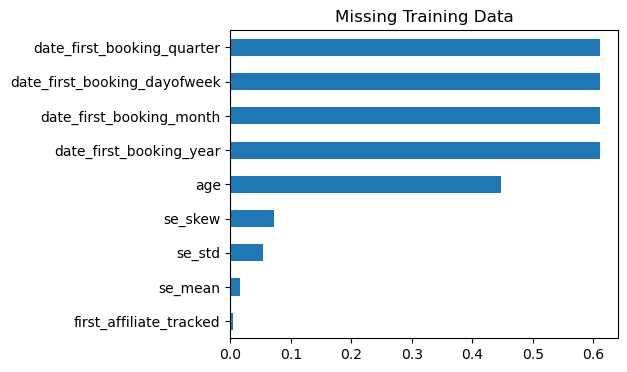

In [15]:
train_missingness_barplot = (X_train
                             .isna()
                             .mean()
                             .where(lambda x: x > 0, np.nan)
                             .dropna()
                             .sort_values()
                             .plot(kind="barh", figsize=(5, 4), title="Missing Training Data"))

Examining missing values for features in the test dataset, because any features with largely missing values may not be useful for training purposes.

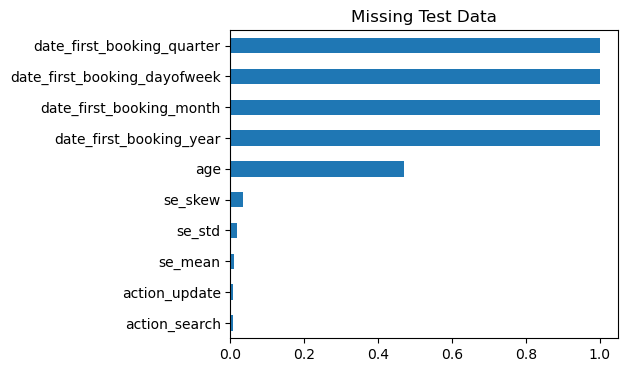

In [16]:
test_missingness_barplot = (X_test
                            .isna()
                            .mean()
                            .sort_values()[-10:]
                            .plot(kind="barh", figsize=(5, 4), title="Missing Test Data"))

Given that the "date_first_booking" feature is completely missing in the test dataset, it will be dropped from both datasets.

In [17]:
dfb_cols = X_train.columns[X_train.columns.str.startswith("date_first_booking")].tolist()

X_train = X_train.drop(dfb_cols, axis=1)
X_test = X_test.drop(dfb_cols, axis=1)

categorical_features = [feat for feat in categorical_features if feat not in dfb_cols]

I will impute data for all other features. Given the relative lack of missing data for the single categorical feature ("first_affiliate_tracked"), I will use a simple imputer to impute the most frequent value. For the numeric features, I will use a KNNImputer to impute values based on the values for similar observations.

##### Creating Preprocessing Pipeline

First, I will create a pipeline for imputing and transforming categorical features.

In [18]:
impute_transform_cat = make_pipeline(
    SimpleImputer(strategy="most_frequent"), 
    OneHotEncoder(handle_unknown="infrequent_if_exist",
                  min_frequency=.01,
                  sparse_output=False)
)

Similarly, I will create a pipeline for imputing and transforming numeric features. To conserve time, I will impute values using a fraction of the training data using a custom KNNImputer. Additionally, I will only power transform highly skewed features using a custom PowerTransformer. 

I built both of these custom transformers, which can be seen in <b>"custom_sklearn_transformers.py"</b>.

In [19]:
impute_transform_num = make_pipeline(
    MinMaxScaler(), 
    KNNImputerSubset(frac=.05, random_state=0), 
    SelectivePowerTransformer(skew_threshold=1.0)
)

I will integrate these two pipelines using a column transformer.

In [20]:
impute_transform_ct = make_column_transformer(
    (impute_transform_cat, categorical_features),
    (impute_transform_num, numeric_features),
    verbose_feature_names_out=False
)

Given that many models require standardized features (e.g., KNN, SVM), I will add a standard scaling step in a final preprocessing pipeline.

In [21]:
preprocessing_pipe = make_pipeline(
    impute_transform_ct,
    StandardScaler()
)

Before feature selection, I will lastly examine the target.

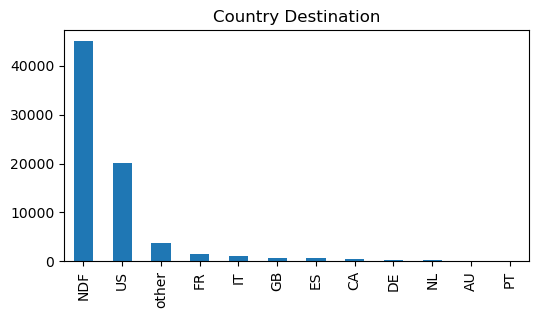

In [22]:
target_plot = (y_train
               .value_counts()
               .plot(kind="bar", figsize=(6, 3), title="Country Destination"))

In [23]:
y_train.value_counts(normalize=True)

NDF      0.610188
US       0.272235
other    0.049516
FR       0.019440
IT       0.013263
GB       0.009903
ES       0.009578
CA       0.005961
DE       0.003387
NL       0.003346
AU       0.002059
PT       0.001124
Name: country_destination, dtype: float64

The majority of people (61.02%) did not book a destination (no destination found; "NDF"). Of those who booked a destination, the United States was the most common choice followed by several European countries. Beyond the 10 most commonly booked countries, all other countries have been encoded as "other".

### Feature Selection

##### Examining Bivariate Distributions 

I will first examine bivariate distributions between categorical features and the target. Frequencies have been normalized across categorical feature categories to evaluate the effectiveness of the feature category in distinguishing between target destinations.

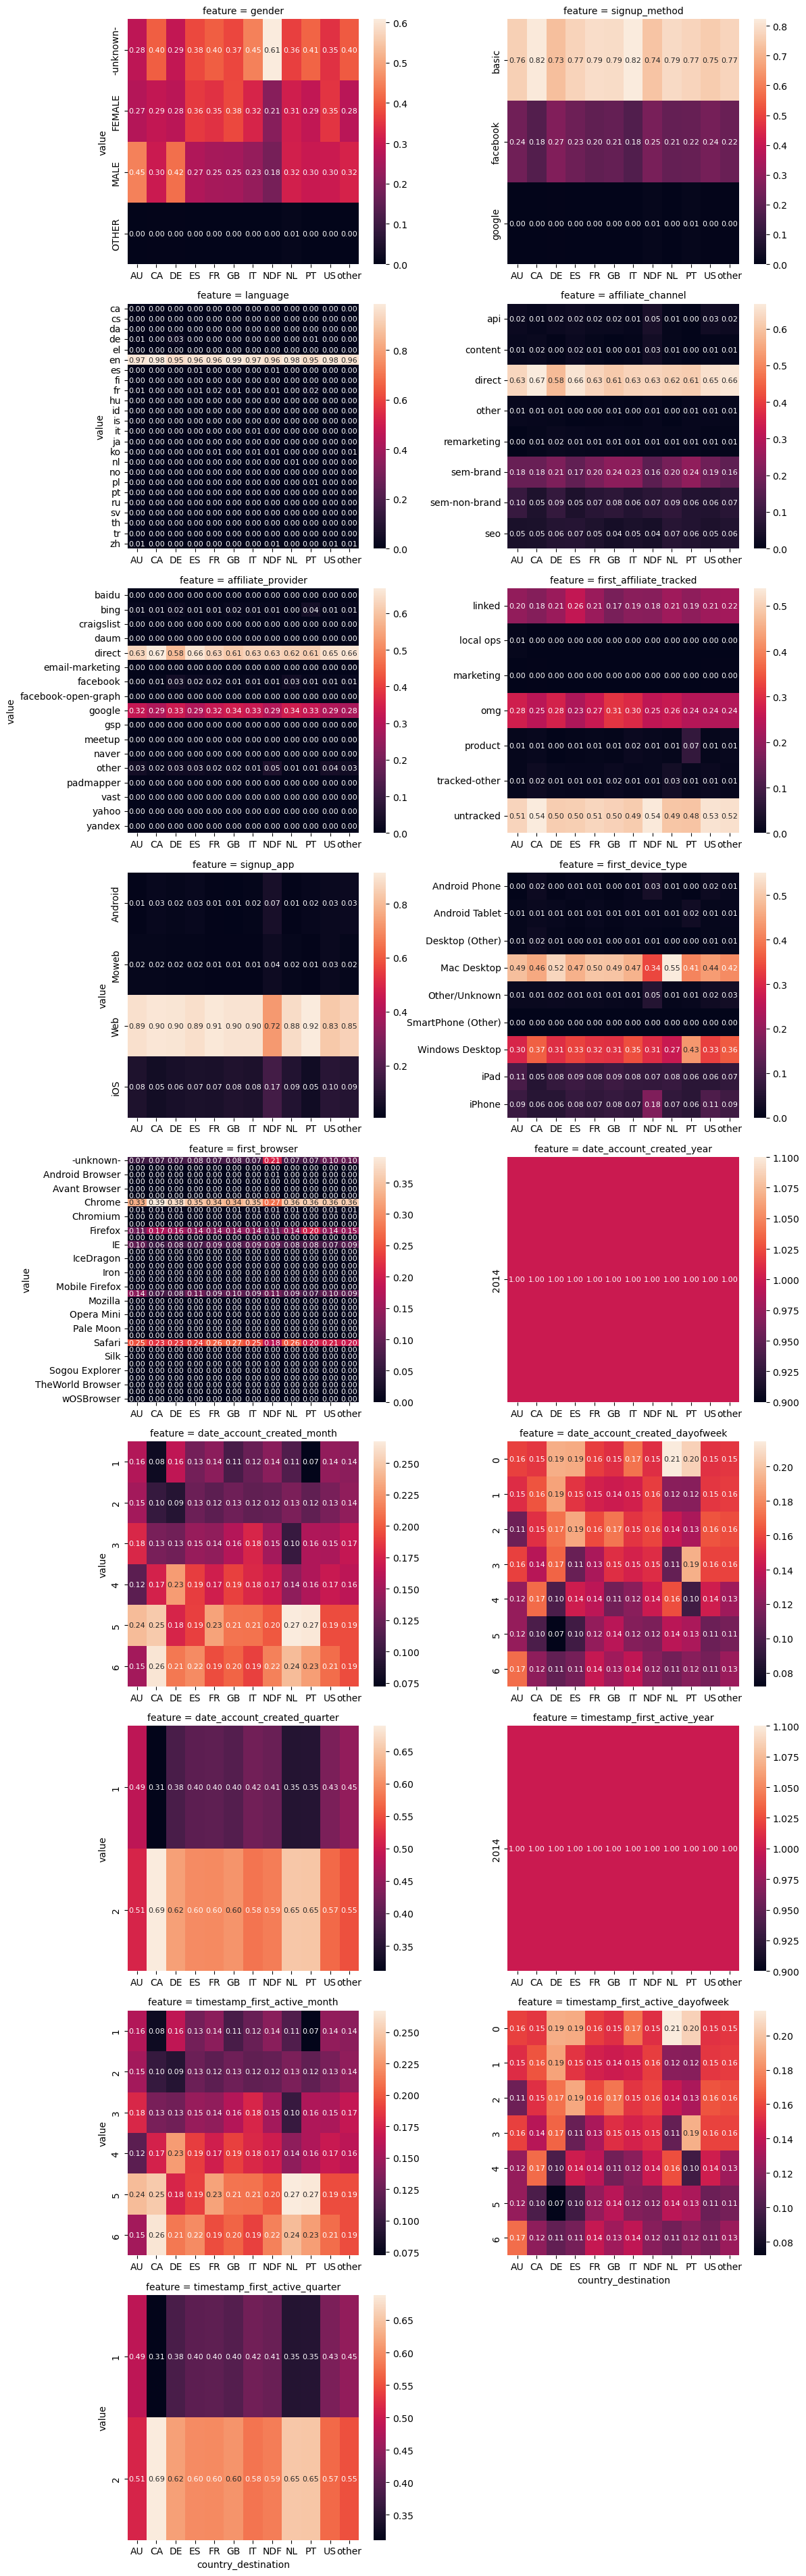

In [24]:
bivariate_visualization(X=X_train[categorical_features],
                        y=y_train,
                        data_type="categorical",
                        ncols=2,
                        figsize=(6, 4.25),
                        annot=True,
                        annot_kws={"size": 8},
                        fmt=".2f")

Based on these visualizations, there are some noteworthy trends that may be useful in distinguishing between destinations:
- Those who did not book a destination were more likely to have their gender and first browser used missing, less likely to sign up through the web, or use a Mac desktop
- Those who booked a trip to the Netherlands are more likely to use a Mac desktop as well as book in May and the second quarter of the year
- Those who booked a trip to Portugal are more likely to use a Windows desktop, less likely to book in January, and more likley to book in May and the second quarter of the year
- Those who booked a trip to Canada were more likely to book in June and the second quarter of the year
- Those who booked a trip to Australia were less likely to book in June and relatively more likely to book in the first quarter of the year

Next, I will examine bivariate distributions between numeric features and the target.

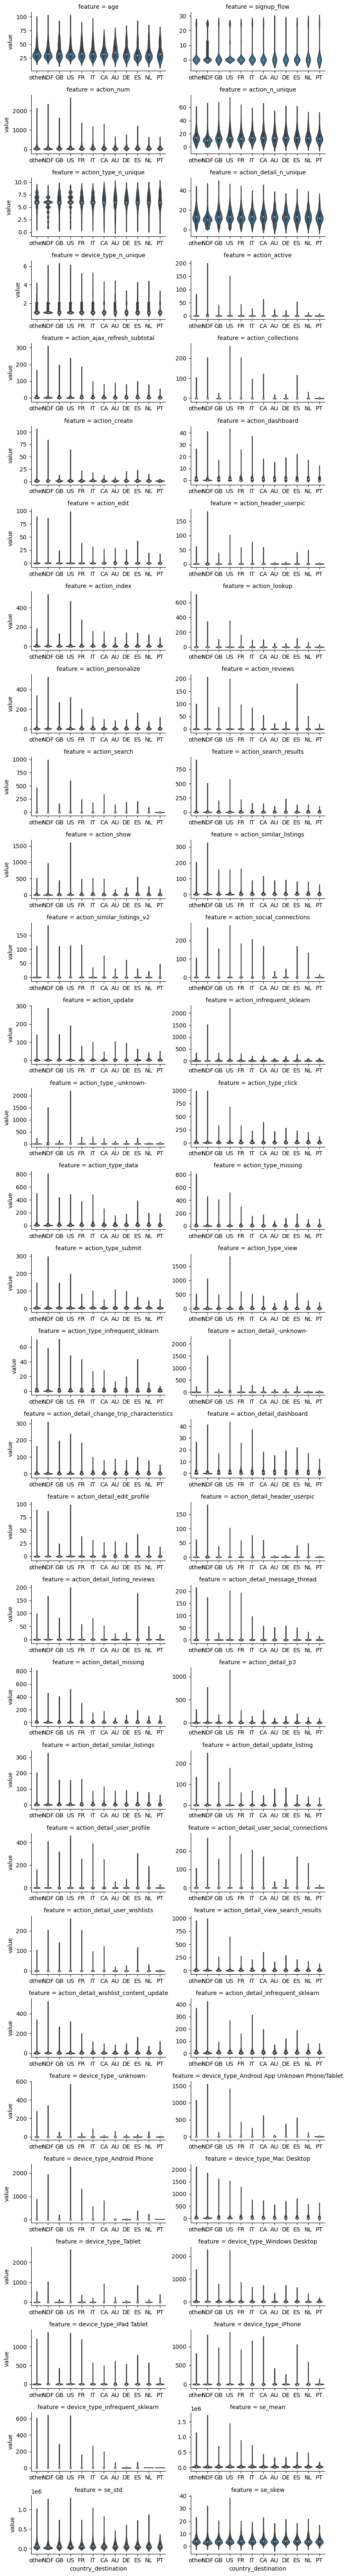

In [25]:
bivariate_visualization(X=X_train[numeric_features],
                        y=y_train,
                        data_type="numeric",
                        ncols=2,
                        figsize=(4, 2))

Most numeric features are heavily positively skewed. Nevertheless, some features appear to distinguish between destinations, particularly those aggregated from session log data (e.g., action_type_n_unique, action_n_unique, se_std).

##### Feature Selection Pipeline

To prevent data leakage, feature selection will occur in a pipeline and will progress through three steps:
1. Variance Threshold: 
    - Remove any zero variance features
2. SelectPercentile:
    - Remove half of the features with the lowest mutual information scores to reduce dimensionality of feature set while keeping features with strongest relations to target
3. RFECVSubset: 
    - Obtain subset of features through RFE using a Decision Tree Classifier and NDCG scores @ 5
    - Will perform RFECV with a subset of data for sake of time by using a custom sklearn transformer that I built (see <b>"custom_sklearn_transformers.py"</b>)

In [26]:
rfecvs = RFECVSubset(
    estimator=DecisionTreeClassifier(random_state=0),
    frac=.15,
    random_state=0,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=0),
    scoring=make_scorer(get_NDCG, needs_proba=True, classes=np.arange(12), k=5),
    n_jobs=-1
)

feature_selection_pipe = make_pipeline(
    VarianceThreshold(), 
    SelectPercentile(mutual_info_classif, percentile=50),
    rfecvs
)

### Complete Model Pipelines

For the purposes of classifying the target, I will train a (1) logistic regression model, (2) k-nearest neighbors classifier, (3) random forest classifier, and (4) support vector machine (with rbf kernel). Each classifier will be included in a larger model pipeline and will be preceded by the preprocessing and feature selection pipelines. 

##### Logistic Regression Pipeline

In [27]:
logr = LogisticRegression(max_iter=10000, solver="saga", random_state=0)

logr_pipe = Pipeline(
    [("preprocessing", preprocessing_pipe),
    ("feature_selection", feature_selection_pipe),
    ("model", logr)]
).set_output(transform="pandas")

##### KNN Pipeline 

In [28]:
knn = KNeighborsClassifier()

knn_pipe = Pipeline(
    [("preprocessing", preprocessing_pipe),
    ("feature_selection", feature_selection_pipe),
    ("model", KNeighborsClassifier())]
).set_output(transform="pandas")

##### Random Forest Pipeline 

In [29]:
rfc = RandomForestClassifier(random_state=0)

rfc_pipe = Pipeline(
    [("preprocessing", preprocessing_pipe),
    ("feature_selection", feature_selection_pipe),
    ("model", rfc)]
).set_output(transform="pandas")

##### SVM Pipeline

Given the large number of observations, fitting a svm with a rbf kernel will take a considerably long time. To save time, I will use a kernel approximation and then fit a linear support vector machine using gradient descent optimization.

In [30]:
svm = make_pipeline(
    Nystroem(random_state=0),
    SGDClassifier(random_state=0)
).set_output(transform="pandas")

svm_pipe = Pipeline(
    [("preprocessing", preprocessing_pipe),
    ("feature_selection", feature_selection_pipe),
    ("model", svm)]
)

### Model Pipeline Tuning and Evaluation

Each model pipeline will be tuned and evaluated using a nested CV approach, which is comprised of two cross-validators. For the first cross-validator (inner loop), the hyperparameters of the model pipeline will be tuned using GridSearchCV with NDCG @ 5 scoring and stratified 3-fold cross-validation. For the second cross-validator (outer loop), the entire hyperparameter gridsearch will be cross-validated with NDCG @ 5 scoring and stratified 5-fold cross-validation. Together, this <a href="https://scikit-learn.org/stable/auto_examples/model_selection/plot_nested_cross_validation_iris.html">nested cross-validation approach</a> will estimate the generalization error of both the model and the hyperparameter search.

Before, tuning and evaluating model pipelines, I will first convert the target to a numeric feature using label encoder.

In [31]:
lab_enc = LabelEncoder()

y_train = pd.Series(lab_enc.fit_transform(y_train),
                    index=y_train.index,
                    name="country_destination")

Next, I will create the scorer and cross-validators used for the nested cross-valdiation. In addition, I will create a dictionary to store the cross-validated scores for each model pipeline.

In [32]:
ndcg_scorer = make_scorer(get_NDCG, needs_proba=True, classes=np.arange(12), k=5)

inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)

outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

clf_scores = dict()

##### Logistic Regression Pipeline Nested Cross-Validation

In [33]:
logr_params = {
    "model__C": np.geomspace(1e-5, 1e5, 5),
}

logr_clf = GridSearchCV(
    estimator=logr_pipe,
    param_grid=logr_params,
    scoring=ndcg_scorer,
    cv=inner_cv,
    n_jobs=-1
)

clf_scores["Logistic_Regression"] = cross_val_score(
    estimator=logr_clf,
    X=X_train,
    y=y_train,
    scoring=ndcg_scorer,  
    cv=outer_cv, 
    n_jobs=-1
)

##### KNN Pipeline Nested Cross-Validation

In [34]:
knn_params = {
    "model__n_neighbors": range(5, 56, 10),
    "model__weights": ["uniform", "distance"]
}

knn_clf = GridSearchCV(estimator=knn_pipe,
                       param_grid=knn_params,
                       scoring=ndcg_scorer,
                       cv=inner_cv,
                       n_jobs=-1)

clf_scores["KNN"] = cross_val_score(
    estimator=knn_clf,
    X=X_train,
    y=y_train,
    scoring=ndcg_scorer,  
    cv=outer_cv, 
    n_jobs=-1
)

##### Random Forest Pipeline Nested Cross-Validation

In [35]:
rfc_params = {
    "model__max_depth": range(5, 56, 10),
    "model__n_estimators": [50, 100, 500]
}

rfc_clf = GridSearchCV(
    estimator=rfc_pipe, 
    param_grid=rfc_params,
    scoring=ndcg_scorer,
    cv=inner_cv,
    n_jobs=-1
)

clf_scores["Random_Forest"] = cross_val_score(
    estimator=rfc_clf,
    X=X_train,
    y=y_train,
    scoring=ndcg_scorer,  
    cv=outer_cv, 
    n_jobs=-1
)

##### SVM Pipeline Nested Cross-Validation

Note that the SVM pipeline cross-validation requires a custom scorer (svm_ndcg_scorer), because the predict_proba method is not available for hinge loss (SVM).

In [36]:
svm_params = {
    "model__nystroem__gamma": np.geomspace(1e-4, 1e4, 5),
    "model__sgdclassifier__alpha": np.geomspace(1e-4, 1e4, 5)
} 

svm_clf = GridSearchCV(
    estimator=svm_pipe,
    param_grid=svm_params,
    scoring=svm_ndcg_scorer,
    cv=inner_cv,
    n_jobs=-1
)

clf_scores["SVM"] = cross_val_score(
    estimator=svm_clf,
    X=X_train,
    y=y_train,
    scoring=svm_ndcg_scorer,  
    cv=outer_cv, 
    n_jobs=-1
)

### Model Pipeline Nested Cross-validation Summary

In [37]:
clf_scores_df = pd.DataFrame(clf_scores)

display(clf_scores_df)

,Logistic_Regression,KNN,Random_Forest,SVM
0,0.840607,0.832110,0.843806,0.820269
1,0.842342,0.837915,0.845806,0.456833
2,0.840074,0.834219,0.842297,0.791032
3,0.842556,0.835072,0.843404,0.818786
4,0.839774,0.835101,0.845550,0.820201


In [38]:
display(clf_scores_df.mean())

Logistic_Regression    0.841071
KNN                    0.834883
Random_Forest          0.844173
SVM                    0.741424
dtype: float64

Random Forest gridsearch performed the best.

In [39]:
best_clf = rfc_clf.fit(X_train, y_train)

Examining the best score, best parameters, and feature importances of the best model.

Best NDCG @ 5 score: 0.84
Best parameters: {'model__max_depth': 15, 'model__n_estimators': 500}


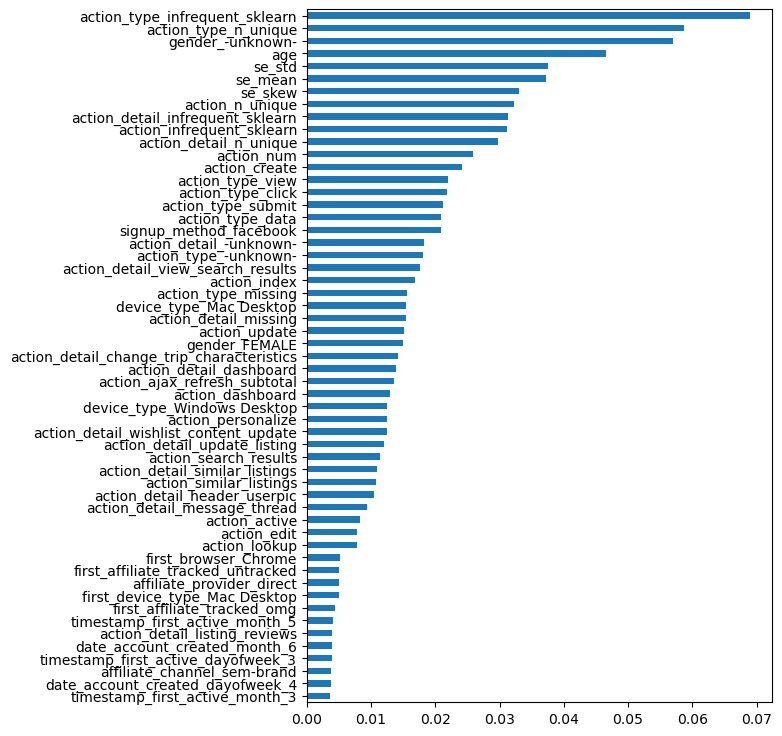

In [48]:
print(f"Best NDCG @ 5 score: {best_clf.best_score_:.2f}",
      f"Best parameters: {best_clf.best_params_}",
      sep="\n")

best_model = best_clf.best_estimator_.named_steps["model"]

feature_importance_plot = (pd.Series(data=best_model.feature_importances_,
                                     index=best_model.feature_names_in_,
                                     name="Importance by Feature")
                           .sort_values()
                           .plot(kind="barh", figsize=(6, 9)))

### Final Predictions

Obtaining and saving final predictions to a csv file. The submission file contains two columns: "user_id" and "country". Each user has five predicted countries rank ordered in terms of predicted probability, which was derived from the final model. Each submission is evaluated with an NDCG score @ 5.

In [41]:
test_top_5 = get_top_5_predictions(predict_proba_array=best_clf.predict_proba(X_test),
                                   classes=best_clf.classes_)

submission = (pd.DataFrame(data=test_top_5, index=X_test.index)
              .stack()
              .reset_index(level=0)
              .rename({0: "country"}, axis=1))

submission["country"] = lab_enc.inverse_transform(submission["country"])

submission.to_csv("CV_submission.csv", index=False)

### Late Submission NDCG: .87646 (on Private Testing Data)